In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window, get_f_KILo_noLC

In [2]:
zmin = 2.0
zmax = 2.5
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
print(chimin, chimax)

5319.735377755262 5978.911518337892


In [4]:
f_Kkappa = get_f_Kkappa()
Lambda = 0.01 # 1 / cMpc, usual cut for HI

# We'll let CMB lensing $\kappa$ still keep it's lightcone evolution

In [5]:
a_of_chibs = ccl.scale_factor_of_chi(cosmo, chibs)
z_of_chibs = 1/a_of_chibs - 1

In [6]:
chi_mean = (chimin + chimax) / 2

In [7]:
f_KLIM = get_f_KI()
f_KLIM_noLC = lambda chi : np.ones_like(chi) * f_KLIM(chi_mean)
f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
f_KLIM_noLC_windowed = apply_window(f_K = f_KLIM_noLC,
                                    chimin = chimin,
                                    chimax = chimax)

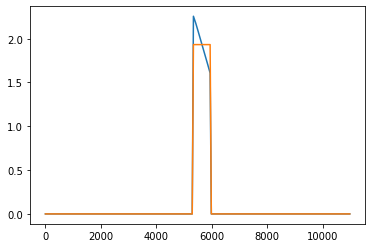

In [8]:
plt.plot(chibs, f_KLIM_windowed(chibs))
plt.plot(chibs, f_KLIM_noLC_windowed(chibs))

In [9]:
Ik = d_delta_integral(f_KLIM_windowed, f_Kkappa)
Ik_noLC = d_delta_integral(f_KLIM_noLC_windowed, f_Kkappa)

In [10]:
Ik_limber = np.zeros_like(Ik)

for ell_idx in range(len(ells)):
    ell = ells[ell_idx]
    Ik_limber[ell_idx] = f_KLIM_windowed(chibs) * f_Kkappa(chibs) / chibs**2 * ccl.linear_matter_power(cosmo, (ell + 1/2) / chibs, 1)

In [11]:
Ik_limber_noLC = np.zeros_like(Ik)

for ell_idx in range(len(ells)):
    ell = ells[ell_idx]
    Ik_limber_noLC[ell_idx] = f_KLIM_noLC_windowed(chibs) * f_Kkappa(chibs) / chibs**2 * ccl.linear_matter_power(cosmo, (ell + 1/2) / chibs, 1)

In [12]:
c1 = plt.cm.rainbow(np.linspace(0, 1, len(ells)))[::-1]
c2 = plt.cm.rainbow(np.linspace(0, 1, len(chibs)))
def interrogate(tmp_field):
    plt.figure(dpi = 300)
    for chib_idx, c in enumerate(c2):
        if(chibs[chib_idx] < chimin or chibs[chib_idx] > chimax):
            continue
        plt.plot(ells, 
                 tmp_field[:,chib_idx],
                 lw = 1,
                 label=chibs[chib_idx], 
                 c=c)
    plt.xlabel('ells')
    plt.xscale('log')
    plt.legend(frameon=False, title='chib')
    plt.show()

    plt.figure(dpi = 300)

    for ell_idx, c in enumerate(c1):
        plt.plot(chibs, 
                 tmp_field[ell_idx], 
                 lw = 1,
                 label=ells[ell_idx] if (ell_idx ==0 or ell_idx == len(c1)-1) else None, 
                 c=c)
    plt.xlabel('chi')
    plt.axvline(chimin, c='k')
    plt.axvline(chimax, c='k')
    plt.legend(frameon=False, title='ells')
    plt.show()

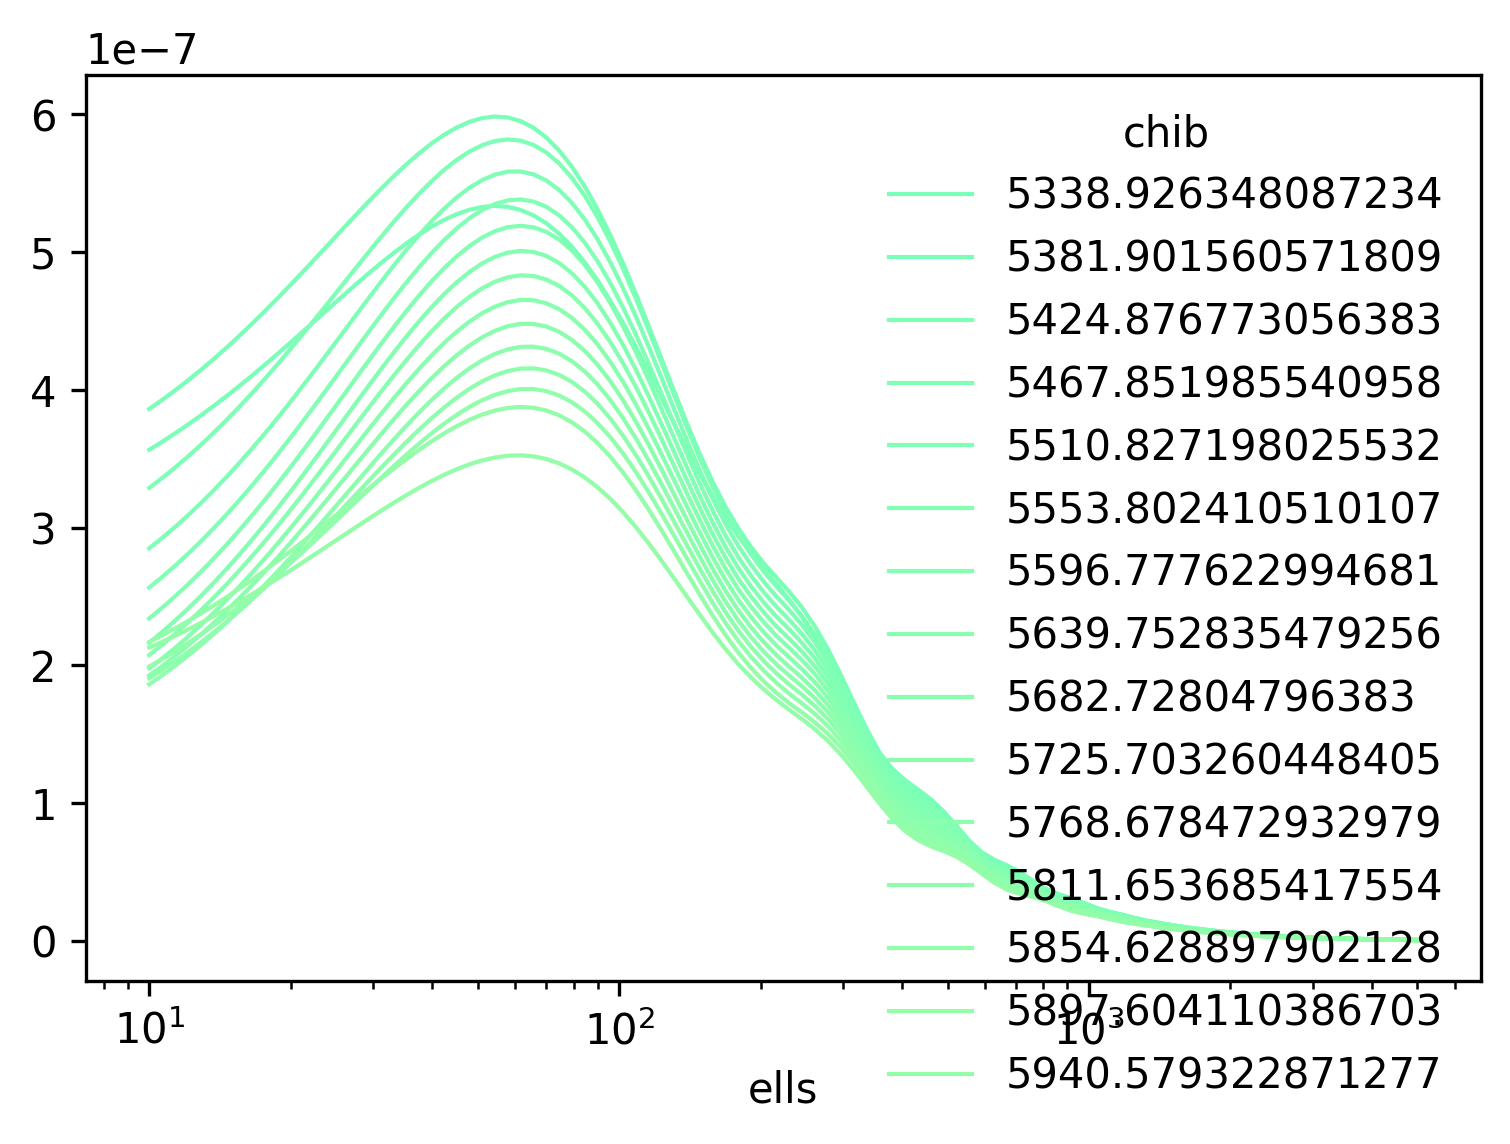

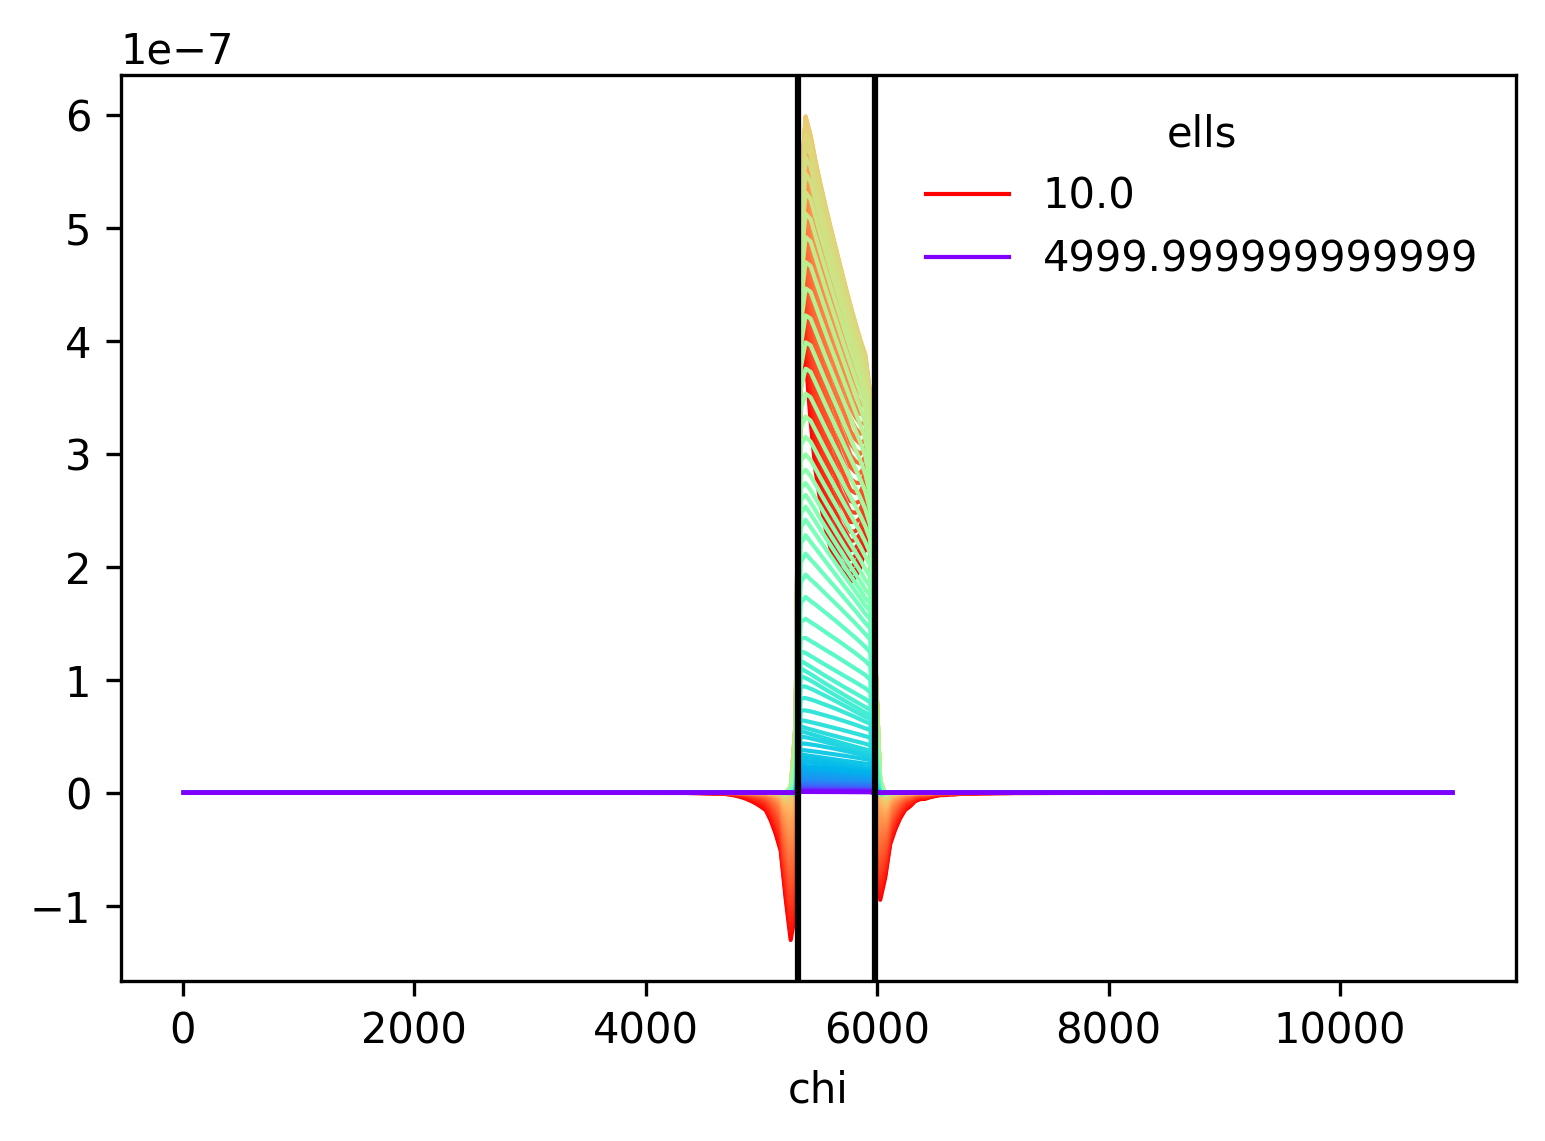

In [13]:
interrogate(Ik)

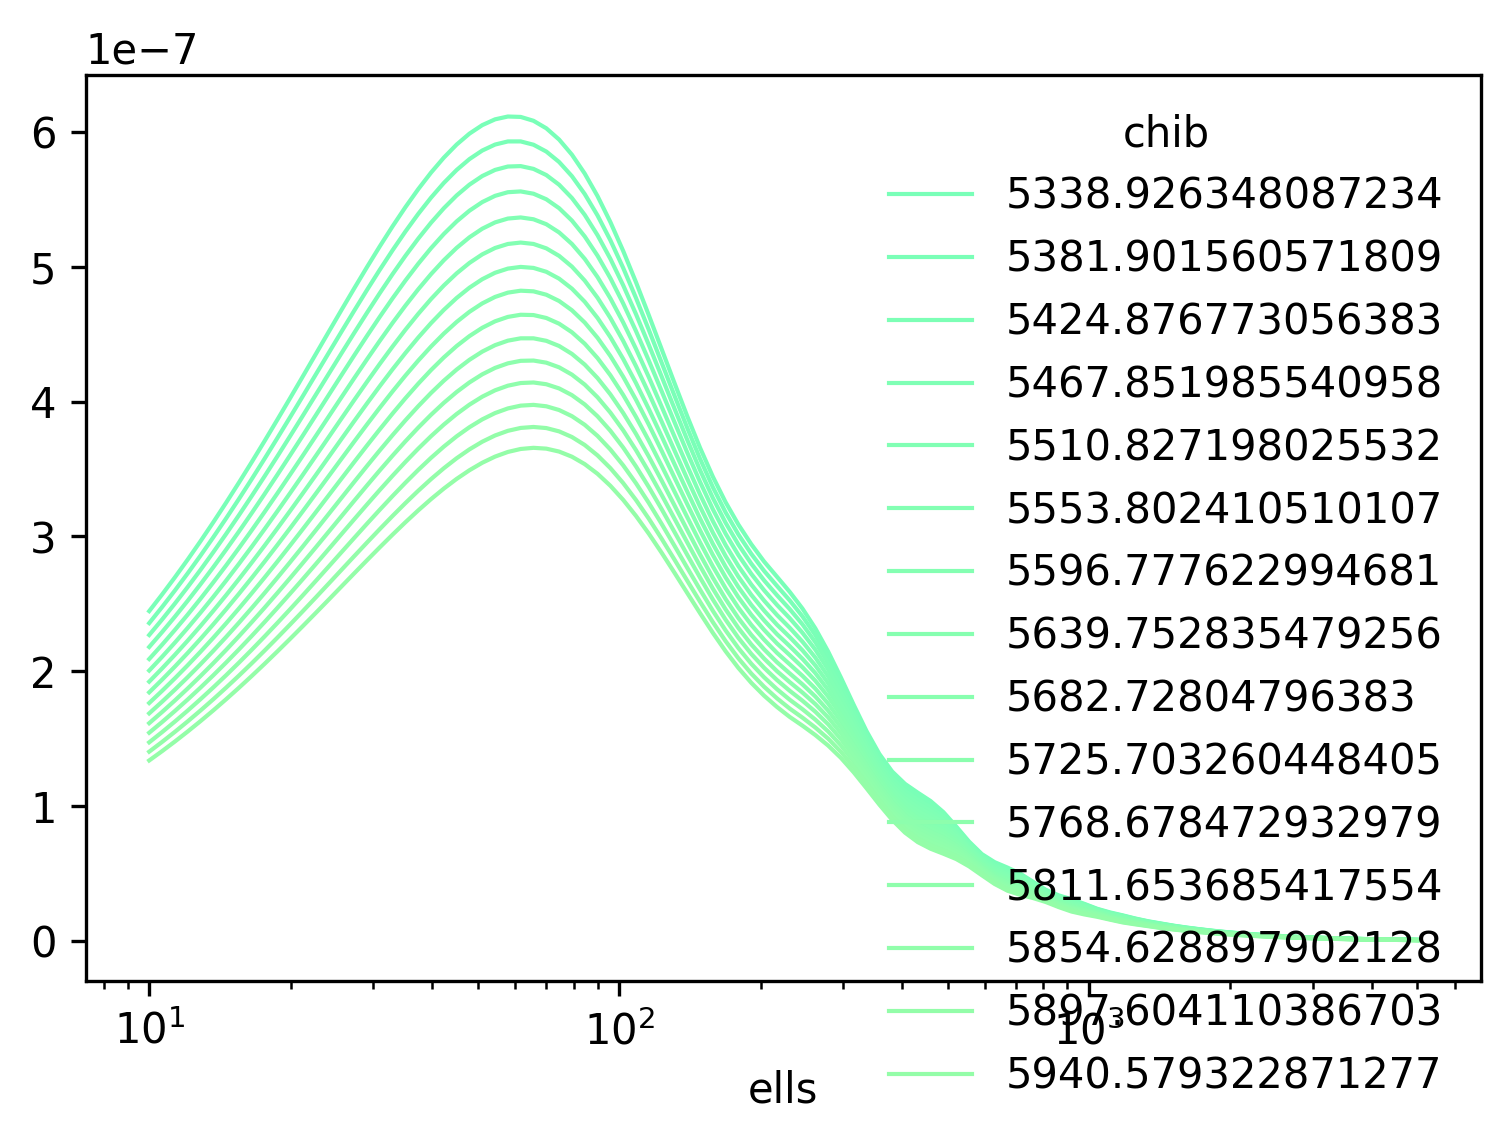

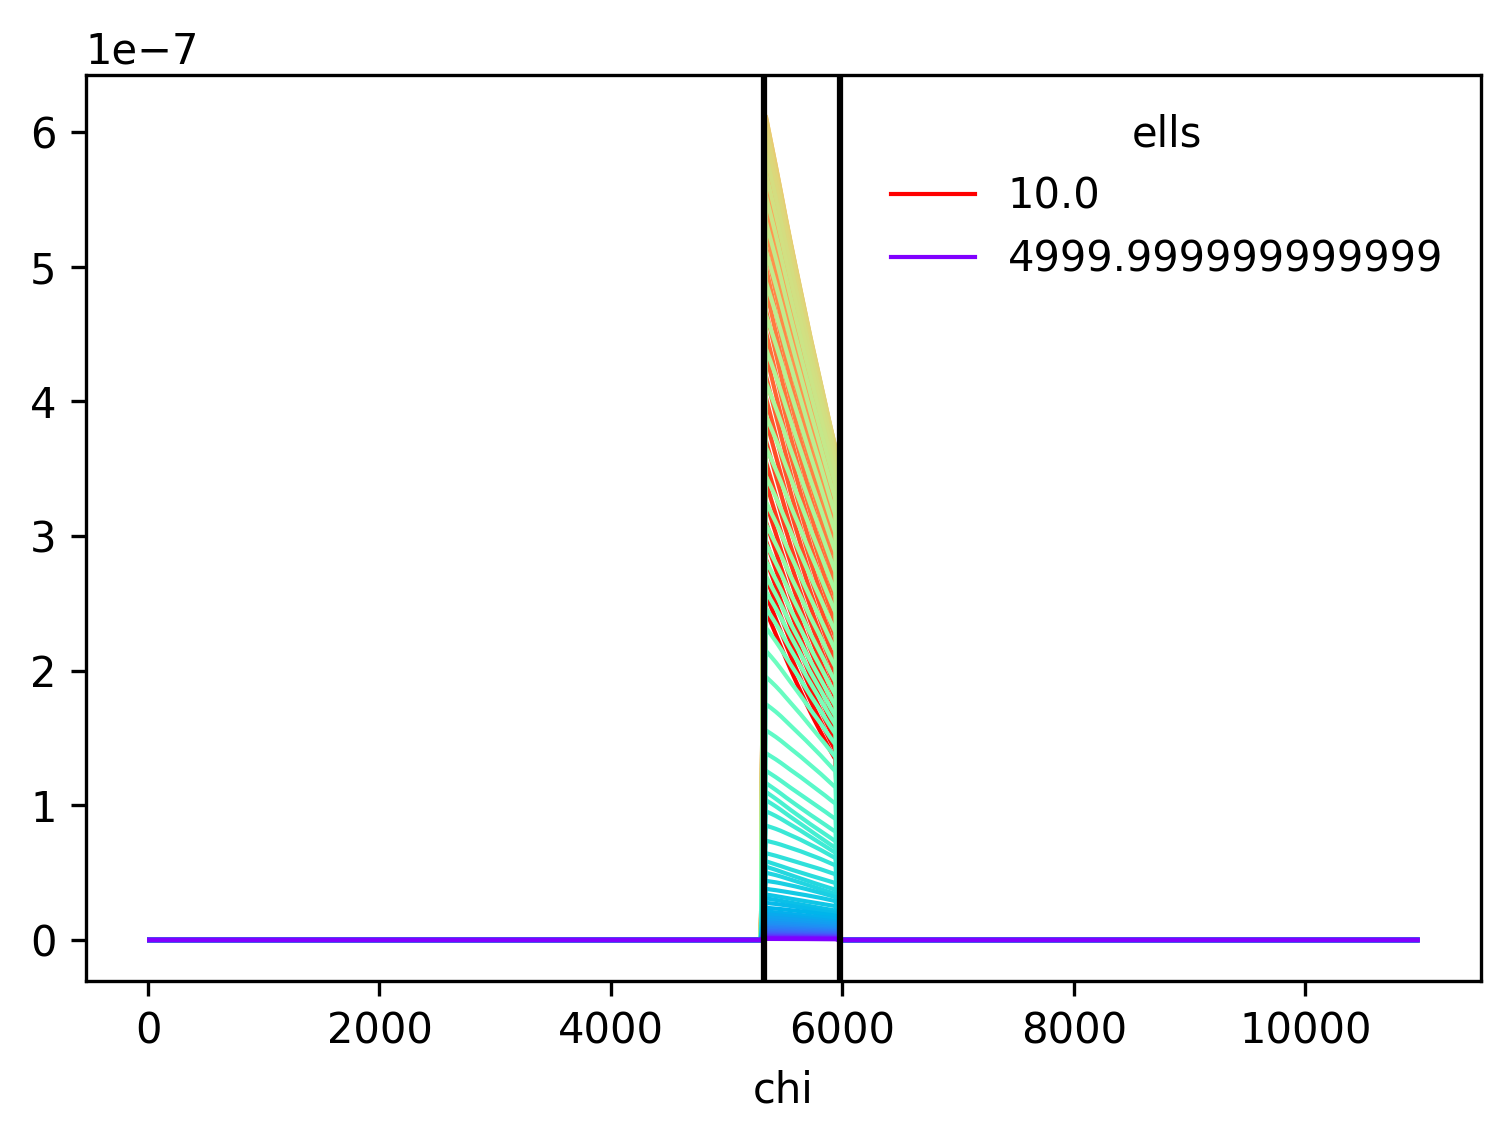

In [14]:
interrogate(Ik_limber)

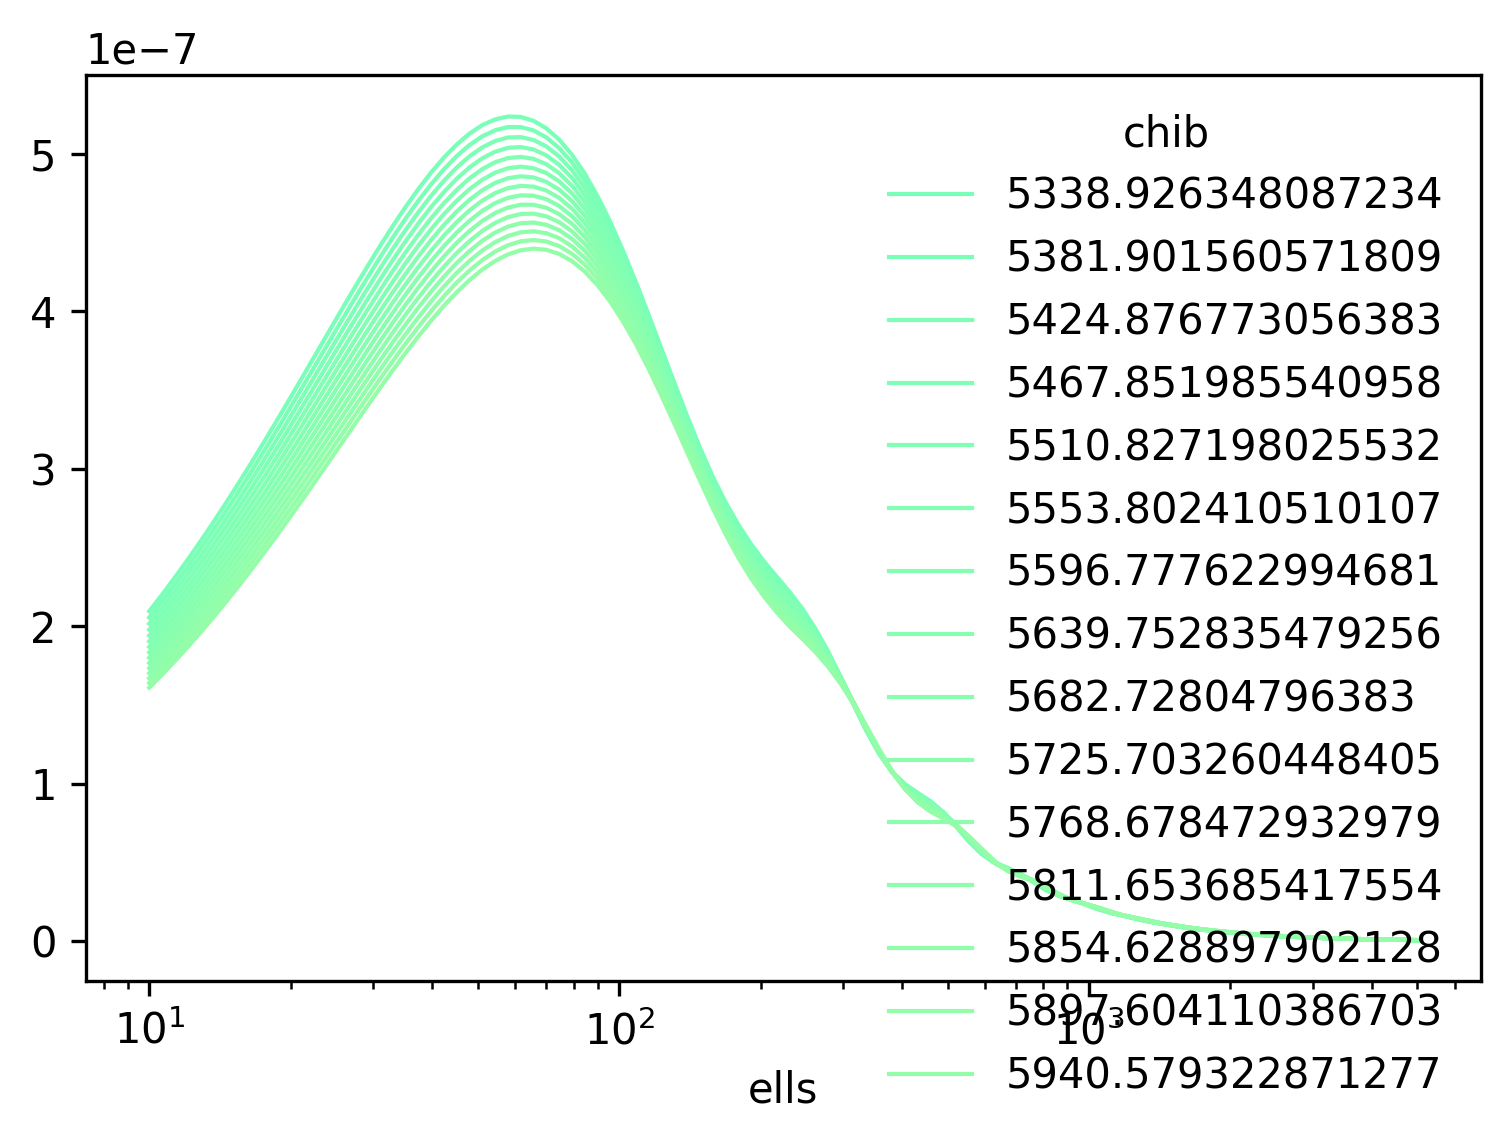

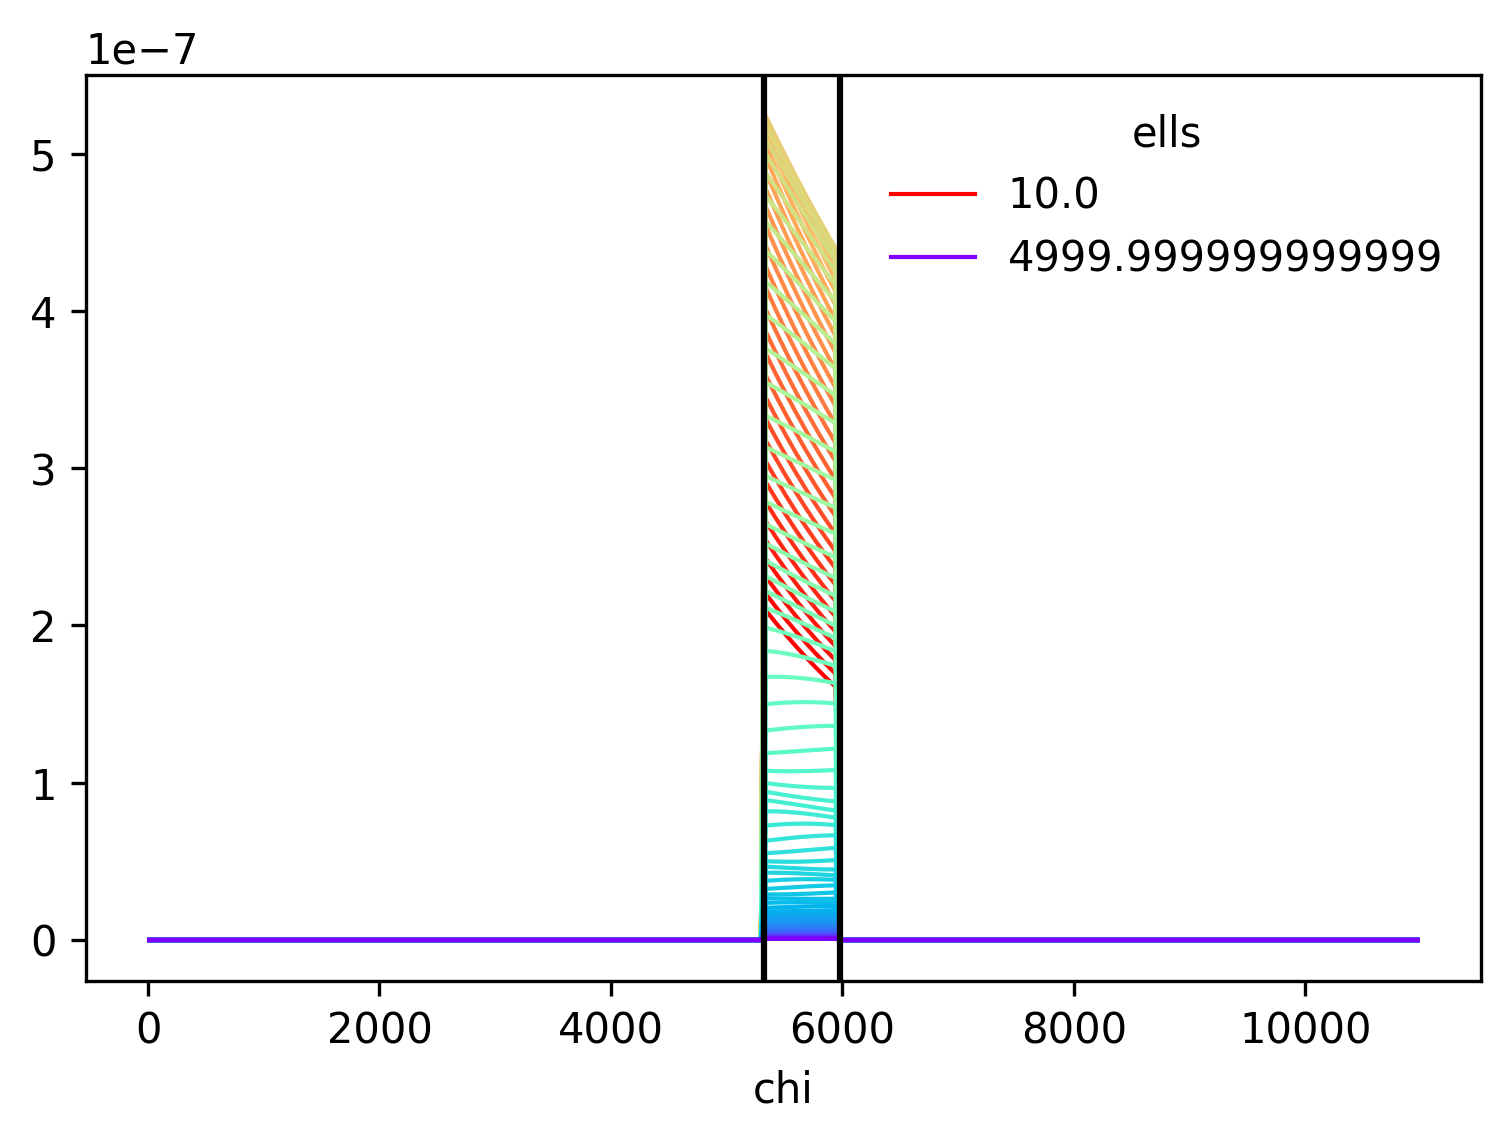

In [15]:
interrogate(Ik_limber_noLC)

# Now $<I^{\sf Lo}\kappa>$

In [26]:
ILok = np.zeros((len(ells), len(chibs)), dtype=np.float128)

from tqdm import trange

for chi_idx in trange(len(chibs)):
    chi = chibs[chi_idx]
    f_KLIMLo   = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    ILok[:, chi_idx]           = d_chib_integral(f_KLIMLo_windowed, f_Kkappa)

100%|██████████| 256/256 [01:11<00:00,  3.60it/s]


In [16]:
ILok_limber = np.zeros((len(ells), len(chibs)), dtype=np.float128)
ILok_limber_noLC = np.zeros((len(ells), len(chibs)), dtype=np.float128)

from tqdm import trange

for chi_idx in trange(len(chibs)):
    chi = chibs[chi_idx]
    f_KLIMLo   = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo_noLC = get_f_KILo_noLC(external_chi = chi,
                                   Lambda = Lambda,
                                   mean = f_KLIM(chi_mean))
    
    f_KLIMLo_windowed       = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    f_KLIMLo_no_LC_windowed = apply_window(f_K = f_KLIMLo_noLC,
                                     chimin = chimin,
                                     chimax = chimax)    

    ILok_limber[:, chi_idx]      = limber_cross_vectorized(f_KLIMLo_windowed, f_Kkappa)
    ILok_limber_noLC[:, chi_idx] = limber_cross_vectorized(f_KLIMLo_no_LC_windowed, f_Kkappa)

100%|██████████| 256/256 [00:00<00:00, 301.67it/s]


In [17]:
from matplotlib import colors

def asdf(field):
    eps = 1e-8
    plt.figure(figsize=(3.5,3), dpi=300, facecolor='w',)
    cs = plt.contourf(chibs, ells, field, levels=2**10,
                      cmap='seismic',
                      norm=colors.TwoSlopeNorm(vmin=field.min()-eps, vcenter=0, vmax=field.max()))
    plt.yscale('log')
    plt.xlabel(r'$\chi$')
    plt.ylabel(r'$\ell$')

    for c in cs.collections:
        c.set_rasterized(True)


    plt.colorbar()

/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


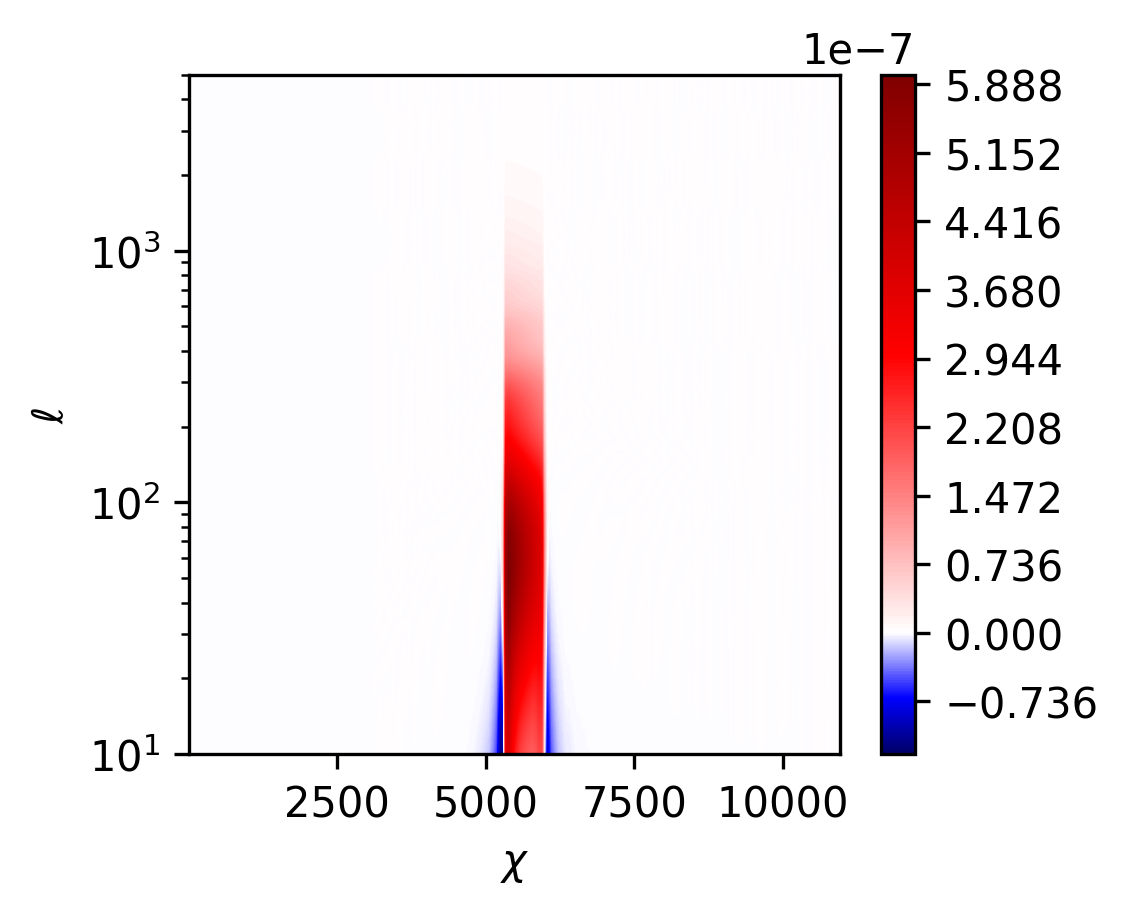

In [27]:
asdf(Ik)

Locator attempting to generate 1021 ticks ([0.0, ..., 6.12e-07]), which exceeds Locator.MAXTICKS (1000).
/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


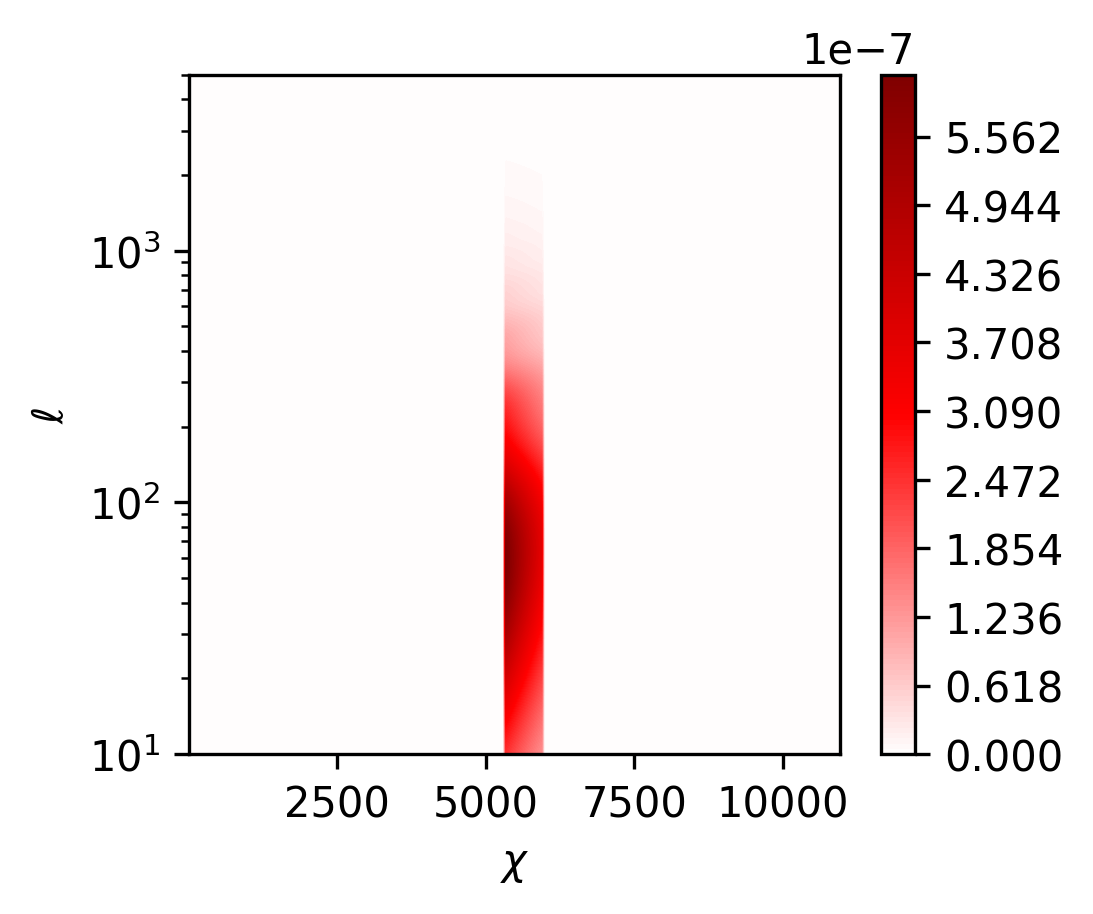

In [18]:
asdf(Ik_limber)

/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


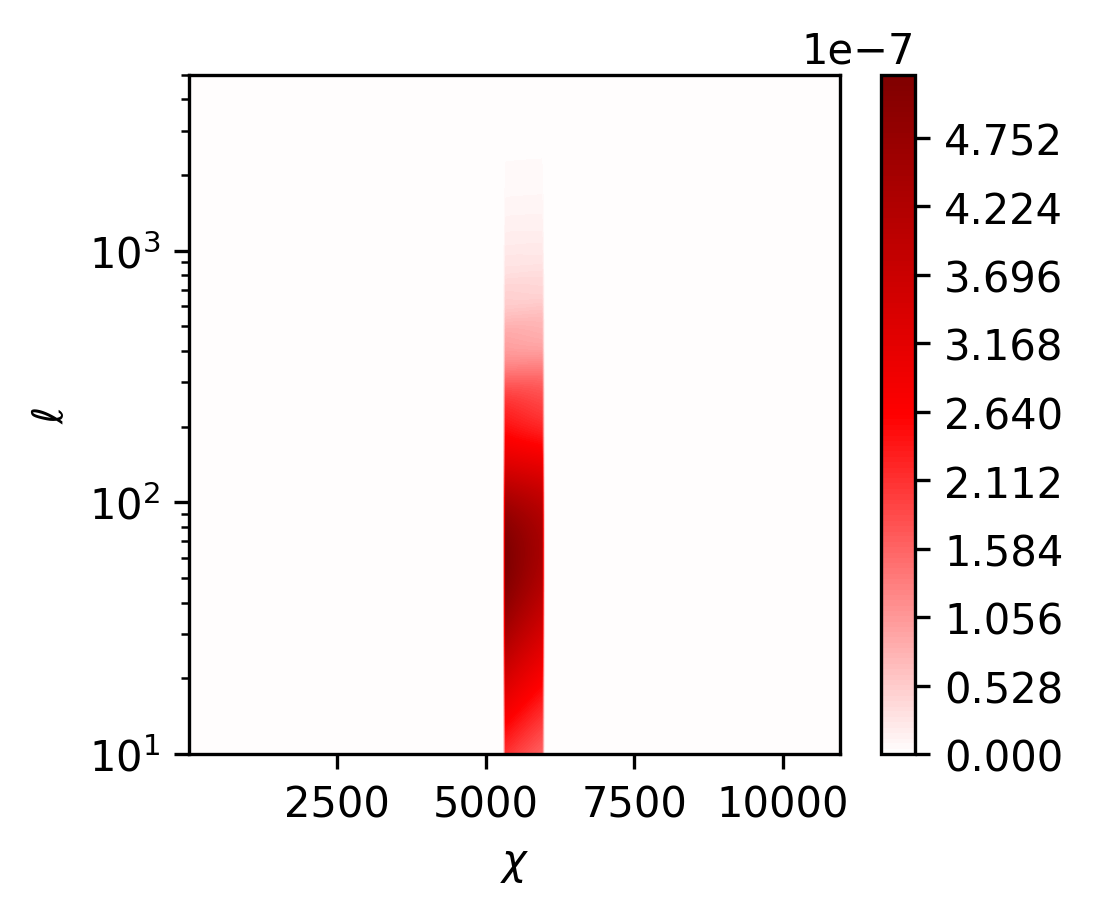

In [19]:
asdf(Ik_limber_noLC)

# IHI Kappa

In [28]:
IHi_kappa = Ik - ILok


In [20]:
IHi_kappa_limber = Ik_limber - ILok_limber
IHi_kappa_limber_noLC = Ik_limber_noLC - ILok_limber_noLC

/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


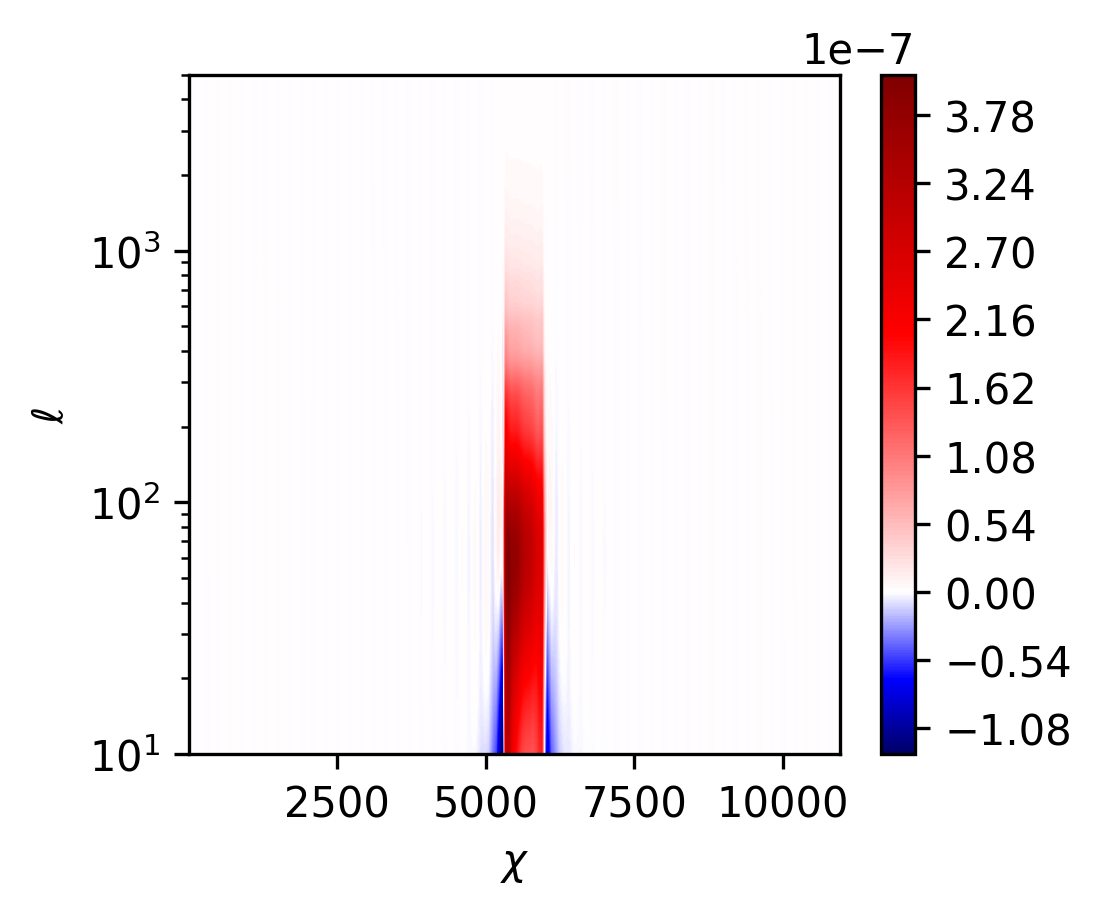

In [29]:
asdf(IHi_kappa)

/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


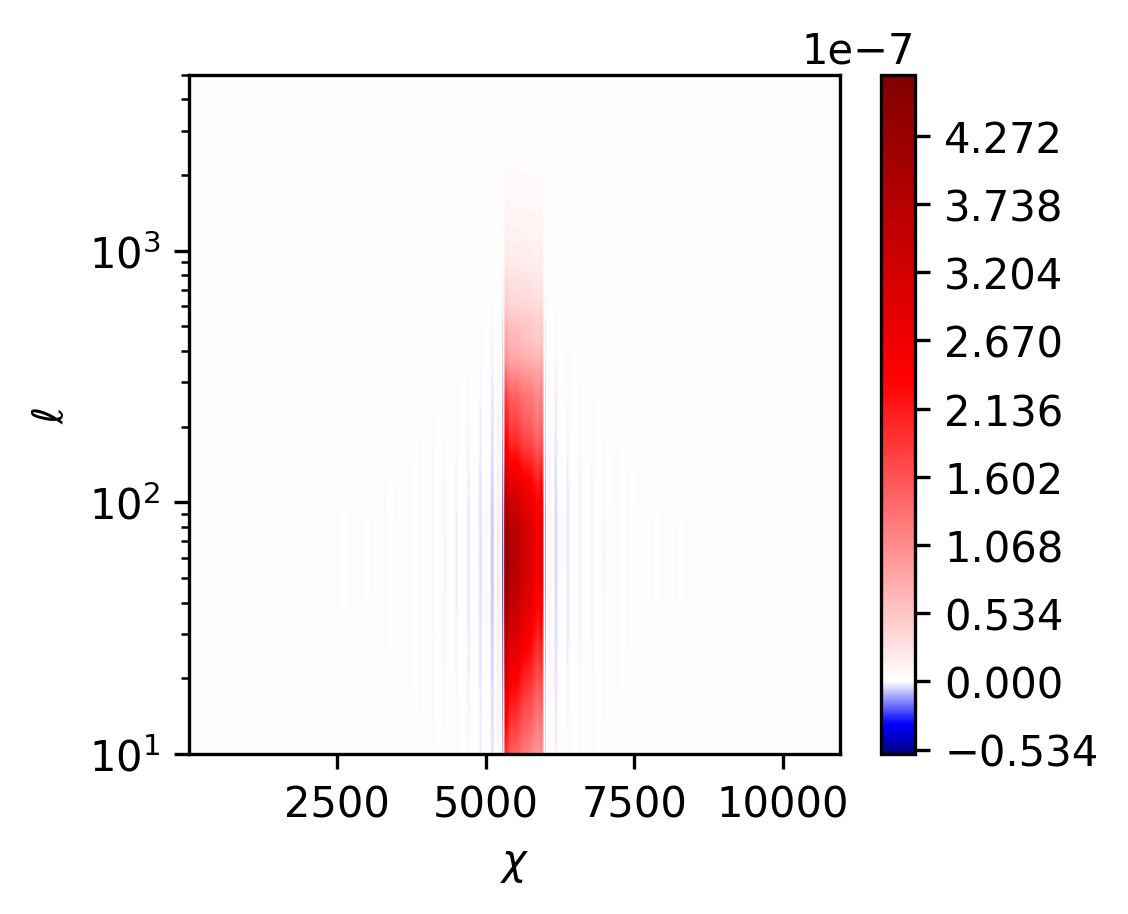

In [23]:
asdf(IHi_kappa_limber)

/tmp/ipykernel_19764/1576480673.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


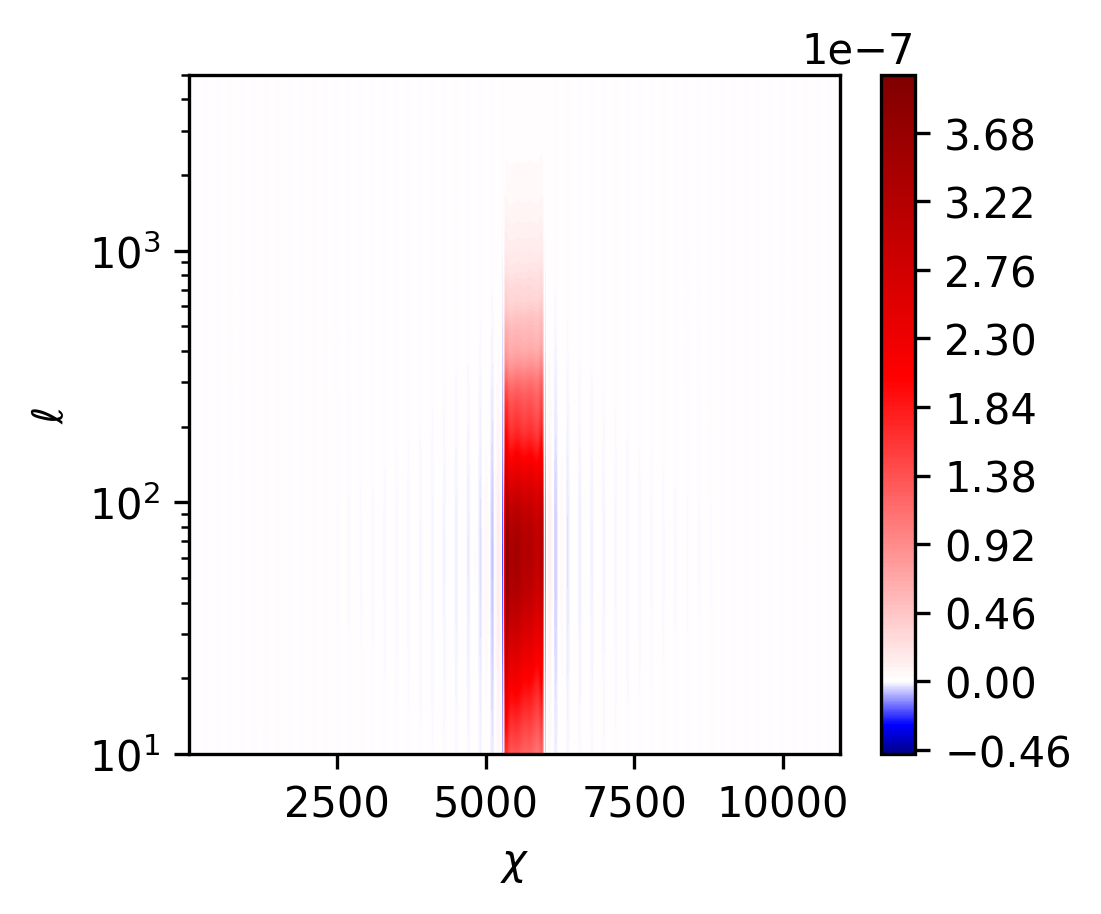

In [24]:
asdf(IHi_kappa_limber_noLC)

100%|██████████| 100/100 [00:00<00:00, 2224.69it/s]
/tmp/ipykernel_19764/2739438315.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


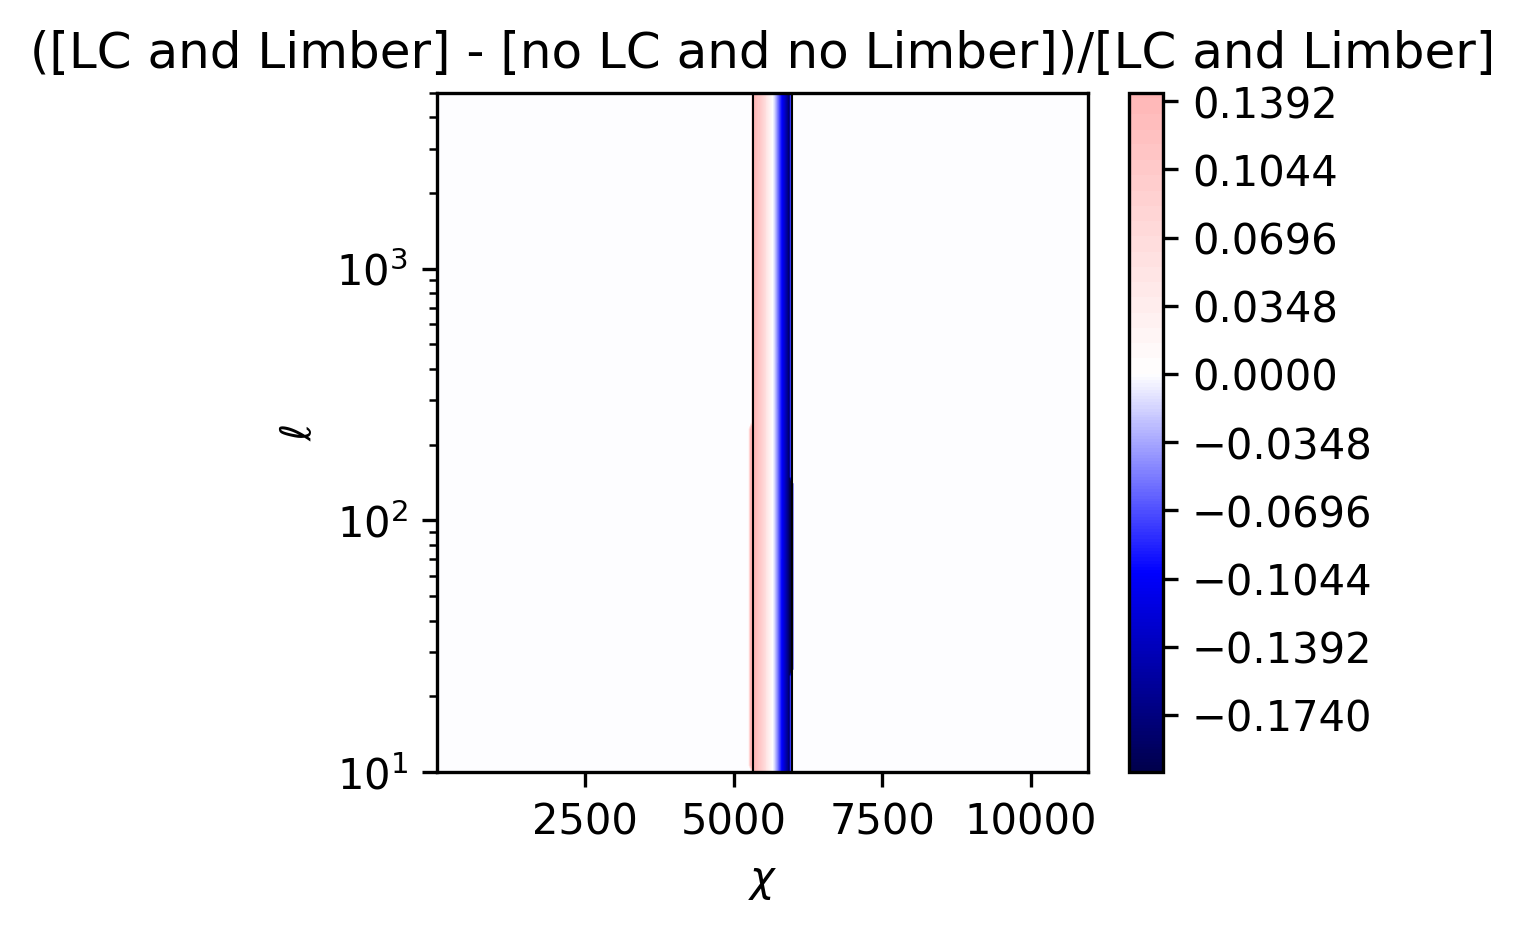

In [33]:
from matplotlib import colors
ratio = np.zeros_like(IHi_kappa_limber)
scale = np.max(np.abs(IHi_kappa_limber))
frac_diff = ((IHi_kappa_limber-IHi_kappa_limber_noLC)/IHi_kappa_limber)
for _a in trange(len(IHi_kappa_limber)):
    for _b in range(len(IHi_kappa_limber[_a])):
        if(np.abs(IHi_kappa_limber[_a][_b])/scale > 5e-2 or (chibs[_b] < chimax and chibs[_b]> chimin)):
            ratio[_a,_b] = frac_diff[_a,_b]

plt.figure(figsize=(3.5,3), dpi=300, facecolor='w',)
cs = plt.contourf(chibs, ells, ratio, levels=2**10,
                  cmap='seismic',
                  norm=colors.TwoSlopeNorm(vmin=ratio.min(), 
                                           vcenter=0, 
                                           vmax=1))

plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\ell$')
plt.axvline(chimin, lw=0.5, c='k')
plt.axvline(chimax, lw=0.5, c='k')

for c in cs.collections:
    c.set_rasterized(True)


plt.title(r"([LC and Limber] - [no LC and no Limber])/[LC and Limber]")

plt.colorbar()

100%|██████████| 100/100 [00:00<00:00, 2229.47it/s]
/tmp/ipykernel_19764/367739780.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cs.collections:


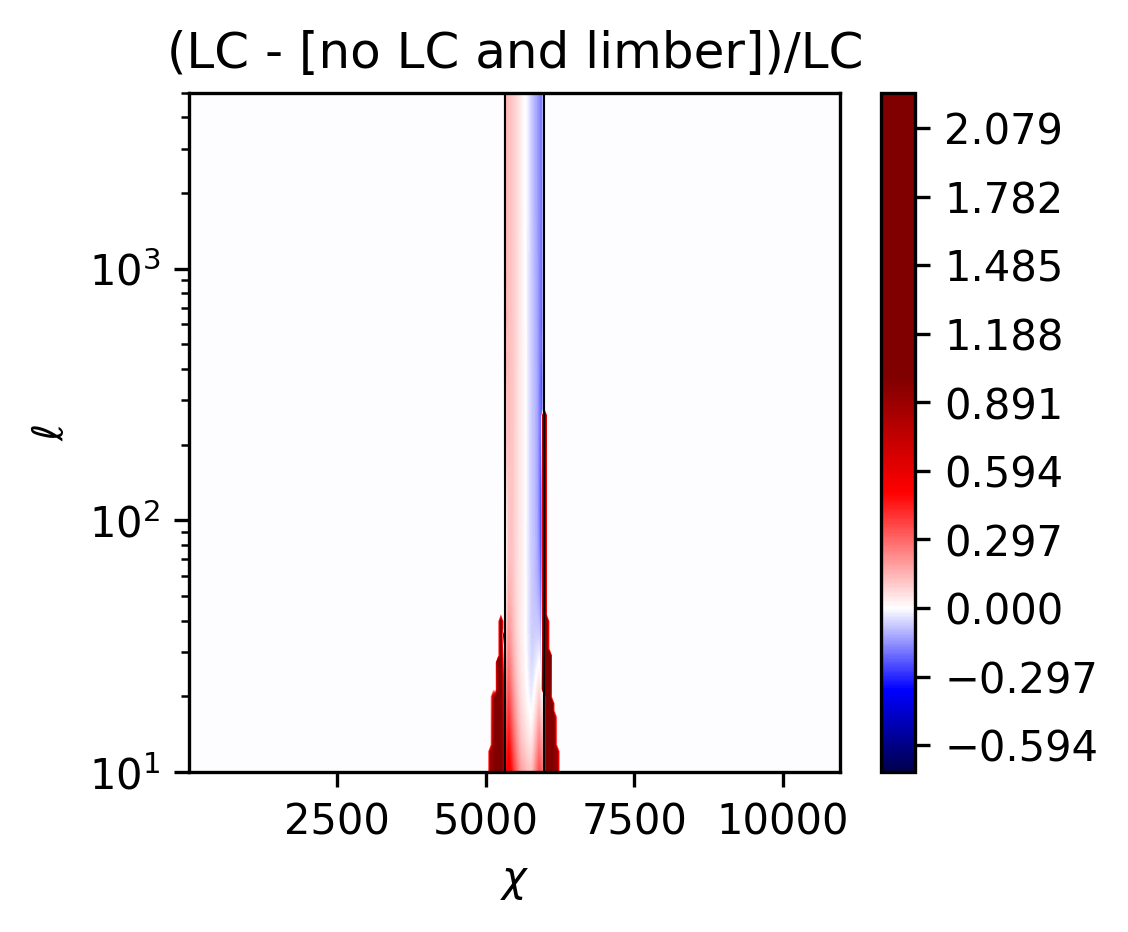

In [32]:
from matplotlib import colors
ratio = np.zeros_like(IHi_kappa)
scale = np.max(np.abs(IHi_kappa))
frac_diff = ((IHi_kappa-IHi_kappa_limber_noLC)/IHi_kappa)
for _a in trange(len(IHi_kappa)):
    for _b in range(len(IHi_kappa[_a])):
        if(np.abs(IHi_kappa[_a][_b])/scale > 5e-2 or (chibs[_b] < chimax and chibs[_b]> chimin)):
            ratio[_a,_b] = frac_diff[_a,_b]

plt.figure(figsize=(3.5,3), dpi=300, facecolor='w',)
cs = plt.contourf(chibs, ells, ratio, levels=2**10,
                  cmap='seismic',
                  norm=colors.TwoSlopeNorm(vmin=ratio.min(), 
                                           vcenter=0, 
                                           vmax=1))

plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\ell$')
plt.axvline(chimin, lw=0.5, c='k')
plt.axvline(chimax, lw=0.5, c='k')

for c in cs.collections:
    c.set_rasterized(True)


plt.title(r"(LC - [no LC and limber])/LC")

plt.colorbar()